In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression

Duplicate key in file '/Users/pin-jutien/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
df = pd.read_csv("train.csv")
target = "TARGET(PRICE_IN_LACS)"


Column	| Description
------|------
POSTED_BY |	Category marking who has listed the property
UNDER_CONSTRUCTION |	Under Construction or Not
RERA	| Rera approved or Not
BHK_NO	| Number of Rooms
BHKORRK	| Type of property
SQUARE_FT | Total area of the house in square feet
READYTOMOVE	| Category marking Ready to move or Not
RESALE	| Category marking Resale or not
ADDRESS	| Address of the property
LONGITUDE |	Longitude of the property
LATITUDE  |	Latitude of the property


In [3]:
# derive sub_city and city from ADDRESS.
def derive_sub_city(x):
    c= x.split(",")
    if len(c) > 2:
        return pd.Series([",".join(c[:2]), c[-1]])
    return pd.Series([c[0], c[1]])
    
# df["city", "state"]  = df.apply(derive_sub_city, axis=1)
df[["SUB_CITY", "CITY"]]  = df["ADDRESS"].apply(lambda x: derive_sub_city(x))

In [4]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),SUB_CITY,CITY
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Ksfc Layout,Bangalore
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Vishweshwara Nagar,Mysore
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Jigani,Bangalore
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Sector-1 Vaishali,Ghaziabad
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,New Town,Kolkata


In [5]:
df.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


<AxesSubplot:>

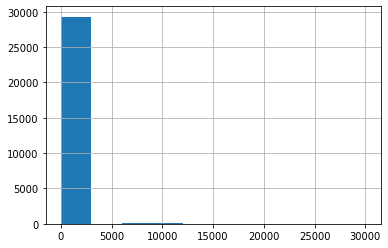

In [6]:
# right skew: heavy tail distribution in the target.
# note: use quantile transformation to 
df[target].hist(bins=10)

In [7]:
df.shape

(29451, 14)

In [8]:
df.columns.tolist()

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'ADDRESS',
 'LONGITUDE',
 'LATITUDE',
 'TARGET(PRICE_IN_LACS)',
 'SUB_CITY',
 'CITY']

In [9]:
# there is no null value within dataset.
df.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
SUB_CITY                 0
CITY                     0
dtype: int64

In [10]:
numerical_features = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
categorical_features = ['POSTED_BY','UNDER_CONSTRUCTION', 'RERA', 'BHK_OR_RK', 
                        'READY_TO_MOVE', 'RESALE', 
                        # 'ADDRESS',
                        'SUB_CITY',
                        'CITY'
                       ]
len(numerical_features), len(categorical_features)

(4, 8)

In [11]:
# summary of numerical features.
# I describe the summary of each numerical features.
# For BHK_NO and SQUARE_FT, those distribution are right skew.
# Their number of std of max value away from mean are 20 and 134 respectively. -> potential outlier
# Their number of std of min value away from mean are 1.58 and 0.01 respectively. -> not outlier
# 
# For LONGITUDE and LATITUDE, the number of std of max value away from mean are 6 and 7. -> potential outlier
# For LONGITUDE and LATITUDE, the number of std of min value away from mean are 9.5 and 18.8. -> potential outlier

# Note: RobustScaler or quantile transformation could be helpful to transform the heavy tail distribution 
# into normal distribution.
num_summary_df = df[numerical_features].describe()
display(num_summary_df)
print("how many std of max value away from mean:")
print((num_summary_df.loc["max"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])
print("how many std of min value away from mean:")
print(abs(num_summary_df.loc["min"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])

,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE
count,29451.000000,2.945100e+04,29451.000000,29451.000000
mean,2.392279,1.980217e+04,21.300255,76.837695
std,0.879091,1.901335e+06,6.205306,10.557747
min,1.000000,3.000000e+00,-37.713008,-121.761248
25%,2.000000,9.000211e+02,18.452663,73.798100
50%,2.000000,1.175057e+03,20.750000,77.324137
75%,3.000000,1.550688e+03,26.900926,77.828740
max,20.000000,2.545455e+08,59.912884,152.962676


how many std of max value away from mean:
BHK_NO.       20.029457
SQUARE_FT    133.866817
LONGITUDE      6.222518
LATITUDE       7.210344
dtype: float64
how many std of min value away from mean:
BHK_NO.       1.583770
SQUARE_FT     0.010413
LONGITUDE     9.510129
LATITUDE     18.810732
dtype: float64


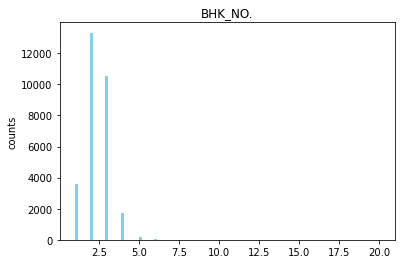

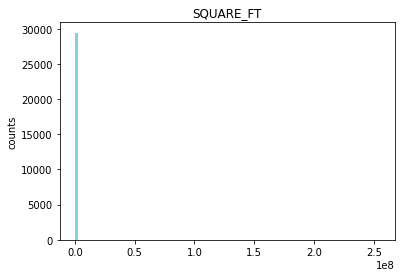

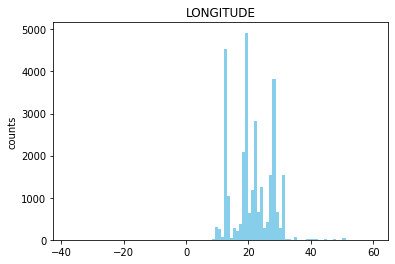

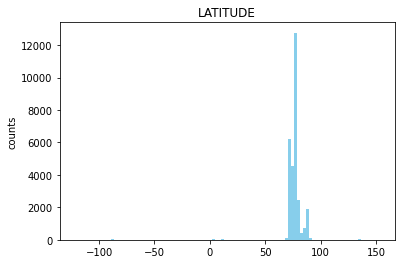

In [12]:
# plot histogram for each numerical features.
for f in numerical_features:
    x = df[f]
    plt.hist(x, bins=100, color="skyblue")
    plt.gca().set(title=f, ylabel='counts')
    plt.show()

In [13]:
# numerical feature: SQUARE_FT has highest correlation = 0.4 with target.
df[numerical_features + [target]].corr()[target]

BHK_NO.                  0.112283
SQUARE_FT                0.402685
LONGITUDE               -0.031112
LATITUDE                -0.017254
TARGET(PRICE_IN_LACS)    1.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

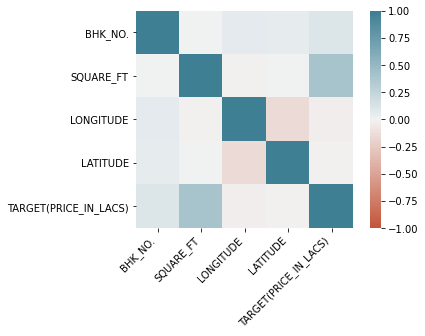

In [14]:

ax = sns.heatmap(
    df[numerical_features + [target]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [15]:
# Calculate the p-value between target and numerical feature.
# it shows that all the numerical features are significally robust with threshold p-value = 0.05
# Especially p-value of 'BHK_NO.' and 'SQUARE_FT' is much smaller than 0.05.
_, pval = f_regression(df[numerical_features], df[target])

# pval
print("p-value: y vs numerical feature")
dict(zip(numerical_features, pval))

p-value: y vs numerical feature


{'BHK_NO.': 3.0340080036920565e-83,
 'SQUARE_FT': 0.0,
 'LONGITUDE': 9.278763453914096e-08,
 'LATITUDE': 0.0030658852286176764}

In [16]:
summary_cat_df = []
for cat_f in categorical_features:
    n = df[cat_f].nunique()
    cl_arr = map(str, list(df[cat_f].unique()))
    class_name = ",".join(cl_arr)
    summary_cat_df += [[cat_f, n, class_name]]
    
summary_cat_df = pd.DataFrame(summary_cat_df, columns=["categorical_features", "number_of_class", "class_name"])
display(summary_cat_df)
# df[categorical_features].describe()

,categorical_features,number_of_class,class_name
0,POSTED_BY,3,"Owner,Dealer,Builder"
1,UNDER_CONSTRUCTION,2,"0,1"
2,RERA,2,"0,1"
3,BHK_OR_RK,2,"BHK,RK"
4,READY_TO_MOVE,2,"1,0"
5,RESALE,2,"1,0"
6,SUB_CITY,5915,"Ksfc Layout,Vishweshwara Nagar,Jigani,Sector-1..."
7,CITY,256,"Bangalore,Mysore,Ghaziabad,Kolkata,Kochi,Jaipu..."


In [42]:
def show_density_stack_box_plot(df, cat, num, figsize=(10,5)):
    # fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    x = cat
    y = num
    fig.suptitle(x+"   vs   "+y, fontsize=20)
    ### distribution
    ax[0].title.set_text('density')
    for i in sorted(df[cat].unique()):
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    ### stacked
    df_noNan = df[df[num].notnull()]
    ax[1].title.set_text('bins')
    breaks = np.quantile(df_noNan[num], q=np.linspace(0,1,11))
    tmp = df_noNan.groupby([cat, pd.cut(df_noNan[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df_noNan[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
        tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1)[sorted(df[cat].unique())].plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
    ### boxplot   
    ax[2].title.set_text('outliers')
    sns.catplot(x=cat, y=num, data=df, kind="violin", ax=ax[2], order=sorted(df[cat].unique()))
    ax[2].grid(True)
    ### fix figure
    plt.close(2)
    plt.close(3)
    plt.show()
    


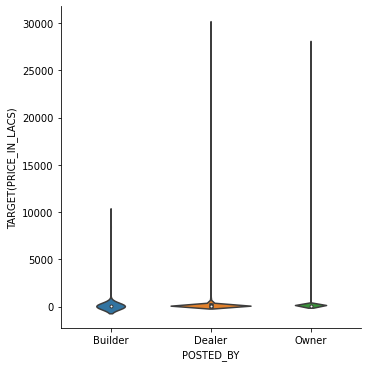

In [41]:
sns.catplot(x="POSTED_BY", y=target, data=df, kind="violin", order=sorted(df["POSTED_BY"].unique()))

/Users/pin-jutien/miniconda/envs/dl-1/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/pin-jutien/miniconda/envs/dl-1/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/pin-jutien/miniconda/envs/dl-1/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

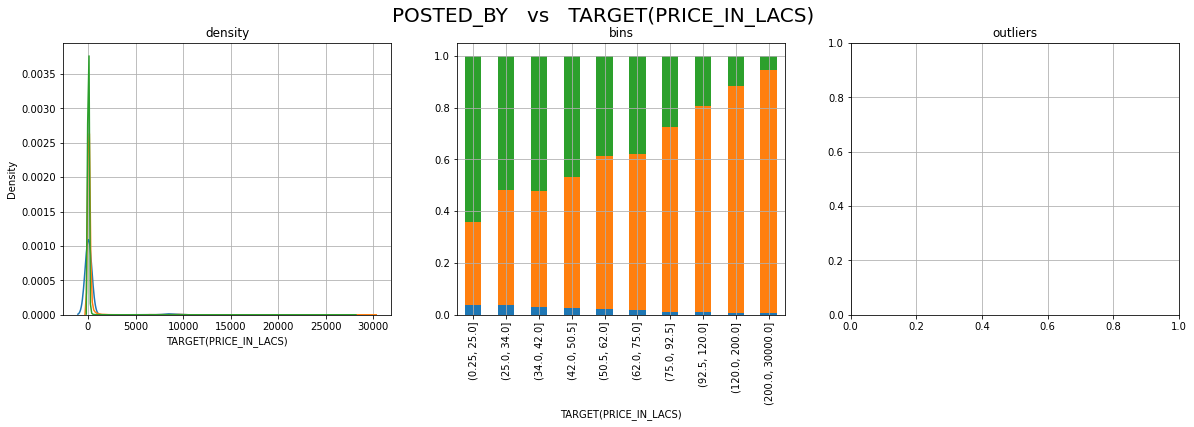

In [44]:
show_density_stack_box_plot(df, cat="POSTED_BY", num=target,figsize=(20,5))

In [18]:
df["POSTED_BY"].value_counts()

Dealer     18291
Owner      10538
Builder      622
Name: POSTED_BY, dtype: int64

In [17]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),SUB_CITY,CITY
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Ksfc Layout,Bangalore
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Vishweshwara Nagar,Mysore
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Jigani,Bangalore
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Sector-1 Vaishali,Ghaziabad
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,New Town,Kolkata


In [120]:
df.shape

(29451, 14)

In [119]:
df["sub_city"].nunique()

5915

In [121]:
df["city"].nunique()

256